## User Similarity Based on tweet Clustering
___

Description :  
  
For this experiment, I selected random 65 users from AmericanCrime TV show and to get the sample of labelled tweets , I chose the tweets that have following hashtags :  

`hashtags = ['#politics', '#art', '#games', '#fashion', '#music', '#news']`  

This allowed be to use thse hashtags as true labels.  


In [1]:
%matplotlib inline
import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [70]:
# imports
import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

##### The input :
___

The file used as input in this experiment is created by selecting specific hashtags from the tweets of the users who tweet about AmericanCrime

In [28]:
filename = "data/tweet_AmericanCrime_selected_labelled.csv"
LABEL = "tweet_AmericanCrime_selected_labelled"
print(filename)

data/tweet_AmericanCrime_selected_labelled.csv


In [6]:
df = pd.read_csv(filename)
print ("Snippet of the dataframe : ")
print (df.head())

   Unnamed: 0       user                                              tweet  \
0           0   29231236  We like having options! #clue #cluegame #vinta...   
1           1   29231236  RT @AdviceToWriters: Mystery is the basic elem...   
2           2  189333010  RT @eggo: At least there's one thing we can ag...   
3           3  189333010  RT @TheRealTahiry: How can I not love her @cia...   
4           4  189333010  RT @USPSbiz: We joined forces with @Poshmarkap...   

       label  
0     #games  
1       #art  
2  #politics  
3   #fashion  
4   #fashion  


##### An Intial look at the topic distribution
___


In [77]:
df_grouped = df.groupby(['user', 'label'])
print(df_grouped.count()[:20])

                    Unnamed: 0  tweet  cluster
user     label                                
10023372 #art                1      1        1
         #fashion            2      2        2
         #games              1      1        1
         #music              1      1        1
         #politics           1      1        1
16582002 #music              1      1        1
         #news               1      1        1
16625554 #music              1      1        1
         #news               1      1        1
19087781 #fashion            1      1        1
         #music              1      1        1
         #news               2      2        2
20942633 #art                2      2        2
         #fashion            6      6        6
         #news               2      2        2
         #politics           2      2        2
24102642 #art                2      2        2
         #music              2      2        2
29231236 #art                2      2        2
         #gam

unique users: 65 
unique labels: 6 


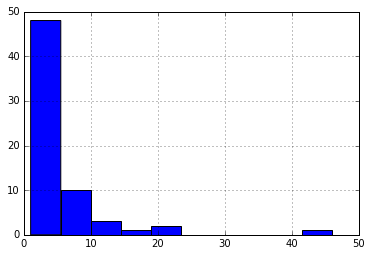

In [102]:
print("unique users: %d " % df.user.nunique())
print("unique labels: %d " % df.label.nunique())


df.user.value_counts().hist()

##### Take the tweets from the dataframe for clustering
___
a snippet of tweets:

In [17]:
# convert the pandas series (tweet text) to numpy array
text = df.iloc[:, 2]
tweet_text = np.array(text)
print(tweet_text[:5])

[ 'We like having options! #clue #cluegame #vintageclue #hitchcockclue #options #games https://t.co/p66KXzLGGn'
 'RT @AdviceToWriters: Mystery is the basic element of all works of art.\nLUIS BUUEL\n#art #literature #writing #writetip'
 "RT @eggo: At least there's one thing we can agree on: Waffles are great. #politics #LeggoMyEggo https://t.co/MzpSu7hCIC"
 'RT @TheRealTahiry: How can I not love her @ciara  #style #fashion #metgala #manusxmachina #metgala2016 #ciara https://t.co/INj9zvdBsU'
 'RT @USPSbiz: We joined forces with @Poshmarkapp to create Posh Post  a #shipping collaboration for #fashion. See how. https://t.co/1riWB']


###### TFIDF model creation

TFIDF model for created:
Preprocessing and tokenization done.

Preprocessing included  
* URL removal
* non-ascii removal
* stop word removal
* slang replacement (acronym replacement)
* TOS tagging (included only verbs, nowns, adverb and adjectives)
* lemmatization


In [105]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )
    
    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model, vectorizer
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model, vectorizer = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)
#print(vectorizer)

print("Created TFIDF ============")
print(tfidf_model.shape)

Created TFIDF ============
(331, 261)


##### GMM EM - clusters estimation
___


In [19]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)

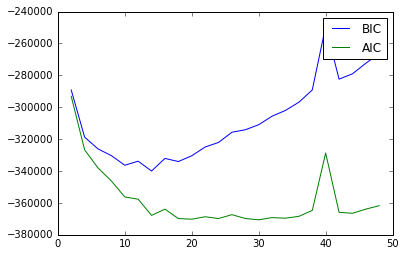

In [20]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -285987              -289960
3             -308369              -314331
4             -319622              -327572
5             -325861              -335800
6             -329586              -341514
7             -334681              -348596
8             -332088              -347992
9             -332687              -350580
10             -338275              -358156
11             -335535              -357405


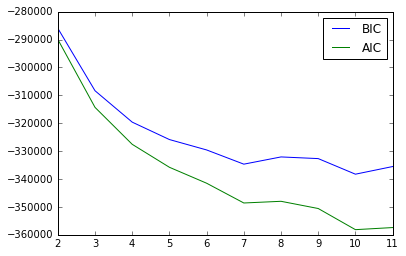

In [21]:
n_estimators = np.arange(2,12, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

##### Eyeballing GMM graph
___

GMM EM gives 7 clusters


##### Running K Means
___

In [29]:
# true labels
t_labels = df.iloc[:, 3]

# run k means :
clusters = 7
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

print(type(cluster))
df.loc[:, 'cluster'] = pd.Series(cluster)
print(df[:5])
df.to_csv("results/kmeans_" + LABEL + ".csv")

Silhouette score                   : 0.057470
Adjusted Rand Score                : 0.506021
Adjusted Mutual Information Score  : 0.521034
Normalized Mutual Information Score: 0.583468
Normalized Mutual Information Score: 0.583468
Homogeniety Score                  : 0.637927
Completeness Score                 : 0.533659
<class 'numpy.ndarray'>
   Unnamed: 0       user                                              tweet  \
0           0   29231236  We like having options! #clue #cluegame #vinta...   
1           1   29231236  RT @AdviceToWriters: Mystery is the basic elem...   
2           2  189333010  RT @eggo: At least there's one thing we can ag...   
3           3  189333010  RT @TheRealTahiry: How can I not love her @cia...   
4           4  189333010  RT @USPSbiz: We joined forces with @Poshmarkap...   

       label  cluster  
0     #games        1  
1       #art        4  
2  #politics        1  
3   #fashion        5  
4   #fashion        5  


In [30]:
# top 10 words in a cluster
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: news roger countrymusic osmanl german rte hockey video gameofthrones throne
Cluster 1: roger politics follow game significant get artsy yesterday time detail
Cluster 2: terminal c4ac event late fashionshow picture mean man loud festival
Cluster 3: video live music roger hiphop newmusic musicvideo jackson artist family
Cluster 4: art roger painting design time message booty gifs artist instant
Cluster 5: fashion style roger good fashionista tag post houseofholland day feel
Cluster 6: music roger song listen moses blue make xx giveaway follow


#### Calculating Similarity
___


In [57]:
# group by clusters
def get_user_tuples(df):
    grouped_user = df.groupby('user')
    grouped_clusters = df.groupby(['user', 'cluster'])
    clusters = df.cluster.unique()
    users = []
    user_names = []
    for name, group in grouped_user:
        user_tuple = []
        total_tweets = len(group)
        for each_clusters in clusters:
            try:
                g = grouped_clusters.get_group((name,each_clusters))
                user_tuple.append(len(g)/total_tweets)
            except KeyError:
                user_tuple.append(0)
        users.append((user_tuple))
        user_names.append((name))
    return users, user_names


In [107]:
user_tuples, user_names = get_user_tuples(df)
print ("Vector tuples : ")
print(user_tuples[:5])

print ("\nUser- Ids : ")
print(user_names[:5])


Vector tuples : 
[[0.5, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0, 0, 0], [0, 0, 0, 0.5, 0.5, 0, 0], [1.0, 0, 0, 0, 0, 0, 0], [0.75, 0, 0.25, 0, 0, 0, 0], [0.25, 0.16666666666666666, 0.5, 0, 0, 0.08333333333333333, 0]]

User- Ids : 
[10023372, 16582002, 16625554, 19087781, 20942633]


##### Pairwise Cosine Similarity
___

In [73]:
dist = cosine_similarity(user_tuples)
print(dist)

[[ 1.          0.20412415  0.8660254  ...,  0.40824829  0.8660254
   0.63828474]
 [ 0.20412415  1.          0.         ...,  0.          0.          0.14213381]
 [ 0.8660254   0.          1.         ...,  0.          1.          0.50251891]
 ..., 
 [ 0.40824829  0.          0.         ...,  1.          0.          0.49746834]
 [ 0.8660254   0.          1.         ...,  0.          1.          0.50251891]
 [ 0.63828474  0.14213381  0.50251891 ...,  0.49746834  0.50251891  1.        ]]


In [111]:
print("user: %d -->"% (user_names[0]), end='')
print(user_tuples[0])
print("user: %d -->"% (user_names[1]), end='')
print(user_tuples[1])
print("\nSimilarity between user: %d and user: %d is"% (user_names[0], user_names[1]))
print(dist[0,1])

user: 10023372 -->[0.5, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0, 0, 0]
user: 16582002 -->[0, 0, 0, 0.5, 0.5, 0, 0]

Similarity between user: 10023372 and user: 16582002 is
0.204124145232


In [112]:
print("user: %d -->"% (user_names[1]), end='')
print(user_tuples[1])
print("user: %d -->"% (user_names[2]), end='')
print(user_tuples[2])
print("\nSimilarity between user: %d and user: %d is"% (user_names[1], user_names[2]))
print(dist[1,2])

user: 16582002 -->[0, 0, 0, 0.5, 0.5, 0, 0]
user: 16625554 -->[1.0, 0, 0, 0, 0, 0, 0]

Similarity between user: 16582002 and user: 16625554 is
0.0
